<a href="https://colab.research.google.com/github/GowthamKumar1626/Machine-Learning-Youtube/blob/master/Computer%20Vision/Flowers_Dataset_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Transfer Learning**
Using MobileNet_V2

Dataset URL: http://download.tensorflow.org/example_images/flower_photos.tgz

## **Importing Libraries**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from sklearn.model_selection import train_test_split

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Download Zip File of Dataset**

In [2]:
URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(
    origin=URL,
    fname="flower_photos.tgz",
    extract=True
)

228818944/228813984 [==============================] - 3s 0us/step


In [3]:
zip_file

'/root/.keras/datasets/flower_photos.tgz'

In [4]:
!ls /root/.keras/datasets/

flower_photos  flower_photos.tgz


In [5]:
base_dir = os.path.join(os.path.dirname(zip_file), "flower_photos")
base_dir

'/root/.keras/datasets/flower_photos'

## **List category names present in dataset**

In [6]:
class_names = [dir for dir in os.listdir(base_dir) if os.path.isdir(base_dir+"/"+dir)]
class_names

['daisy', 'roses', 'sunflowers', 'dandelion', 'tulips']

In [7]:
filenames = list(glob.glob(base_dir+"/*/*.jpg"))
filenames[0]

'/root/.keras/datasets/flower_photos/daisy/676120388_28f03069c3.jpg'

In [8]:
print("Total no.of images present in Dataset: {}".format(len(filenames)))

Total no.of images present in Dataset: 3670


In [9]:
categories = []
for filename in filenames:
  category = filename.split("/")[-2]
  categories.append(category)

## **Making a Dataframe with filenames and Their categories**

In [10]:
dataframe = pd.DataFrame({
    "filename": filenames,
    "category": categories
})

In [11]:
dataframe.head()

,filename,category
0,/root/.keras/datasets/flower_photos/daisy/6761...,daisy
1,/root/.keras/datasets/flower_photos/daisy/2812...,daisy
2,/root/.keras/datasets/flower_photos/daisy/2068...,daisy
3,/root/.keras/datasets/flower_photos/daisy/2476...,daisy
4,/root/.keras/datasets/flower_photos/daisy/3494...,daisy


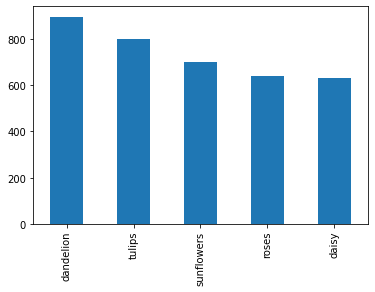

In [12]:
dataframe['category'].value_counts().plot.bar()

## **Plotting a random image**

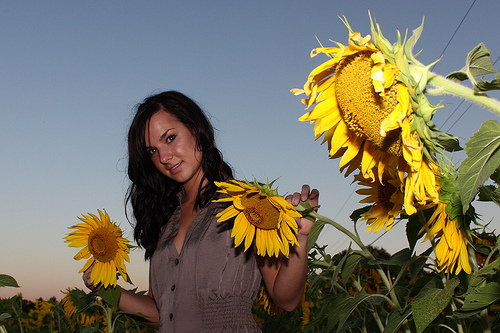

In [13]:
random_image = np.random.choice(filenames)
random_image = tf.keras.preprocessing.image.load_img(random_image)
random_image

In [14]:
random_image = tf.keras.preprocessing.image.img_to_array(random_image)
random_image.shape

(333, 500, 3)

Note: All images are in various shapes

## **Train, test, val Splits**

In [15]:
train_full_df, test_df = train_test_split(dataframe, test_size=0.1, random_state=40)
train_df, val_df = train_test_split(train_full_df, test_size=0.1, random_state=40)

In [16]:
train_df.shape

(2972, 2)

In [17]:
train_length = train_df.shape[0]
test_length = test_df.shape[0]
val_length = val_df.shape[0]

## **Data Augmentation**

Note: If you are using preprocess_input then no need to rescale the image

In [18]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = preprocess_input
)

In [19]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_dir+"/*/",
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 32
)

Found 2972 validated image filenames belonging to 5 classes.


In [20]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [21]:
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    base_dir+"/*/",
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 32
)

Found 331 validated image filenames belonging to 5 classes.


## **Model Building**

In [22]:
mobilenet = MobileNetV2(input_shape=[224, 224, 3], weights='imagenet', include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [23]:
for layer in mobilenet.layers:
  layer.trainable = False

In [24]:
x = tf.keras.layers.GlobalAveragePooling2D()(mobilenet.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

In [25]:
model = tf.keras.models.Model(inputs=mobilenet.input, outputs=x)

In [26]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [27]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #from_logits=false beacause in last predcition layer we specified activation='softmax'
    optimizer='adam',
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch = train_length//32,
    validation_data=val_generator,
    validation_steps=val_length//32,
    callbacks = tf.keras.callbacks.EarlyStopping(patience=3)
)

Epoch 1/20
92/92 [==============================] - 43s 472ms/step - loss: 0.6892 - accuracy: 0.7405 - val_loss: 0.3427 - val_accuracy: 0.8813
Epoch 2/20
92/92 [==============================] - 42s 461ms/step - loss: 0.4305 - accuracy: 0.8371 - val_loss: 0.2809 - val_accuracy: 0.8938
Epoch 3/20
92/92 [==============================] - 42s 459ms/step - loss: 0.3629 - accuracy: 0.8670 - val_loss: 0.2622 - val_accuracy: 0.8906
Epoch 4/20
92/92 [==============================] - 42s 459ms/step - loss: 0.3267 - accuracy: 0.8772 - val_loss: 0.2387 - val_accuracy: 0.9156
Epoch 5/20
92/92 [==============================] - 43s 467ms/step - loss: 0.3118 - accuracy: 0.8844 - val_loss: 0.2833 - val_accuracy: 0.9062
Epoch 6/20
92/92 [==============================] - 44s 476ms/step - loss: 0.2797 - accuracy: 0.8925 - val_loss: 0.2027 - val_accuracy: 0.9312
Epoch 7/20
92/92 [==============================] - 44s 477ms/step - loss: 0.2614 - accuracy: 0.9024 - val_loss: 0.2420 - val_accuracy: 0.9031

## **Plot Model Performace**

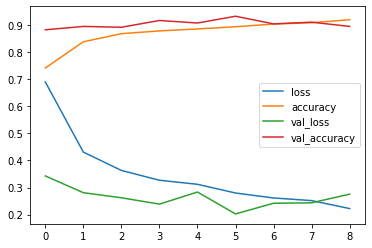

In [33]:
pd.DataFrame(history.history).plot()

In [34]:
test_generator = val_datagen.flow_from_dataframe(
    test_df,
    base_dir+"/*/",
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 32
)

Found 367 validated image filenames belonging to 5 classes.


In [35]:
model.evaluate(test_generator)

12/12 [==============================] - 2s 146ms/step - loss: 0.3651 - accuracy: 0.8610


[0.3651389479637146, 0.8610354065895081]

**Hello Guys! Welcome again**

In previous video we saw how to build a model using transfer learning.
Now we will look into how to predict a single image.

## **Visualization of Predicted Results**

1. First we need to know what are the indices assigned to labels by our Generators.

In [41]:
class_indices = train_generator.class_indices
class_indices #A dictionary

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [42]:
#Exact all keys from above dictionary
class_indices = list(class_indices.keys())
class_indices

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [43]:
test_df.head() #Our test dataframe

,filename,category
3624,/root/.keras/datasets/flower_photos/tulips/141...,tulips
3488,/root/.keras/datasets/flower_photos/tulips/350...,tulips
3038,/root/.keras/datasets/flower_photos/tulips/154...,tulips
1273,/root/.keras/datasets/flower_photos/roses/5180...,roses
3531,/root/.keras/datasets/flower_photos/tulips/350...,tulips


In [45]:
#Extract a random value from test_df
test_df.iloc[1, :].values #Gives row 1 values

array(['/root/.keras/datasets/flower_photos/tulips/3502974120_9f1eceaf8b_n.jpg',
       'tulips'], dtype=object)

In [46]:
#Generate Random values
test_df.iloc[np.random.randint(0, test_length-1), :].values

array(['/root/.keras/datasets/flower_photos/daisy/10391248763_1d16681106_n.jpg',
       'daisy'], dtype=object)

In [47]:
data = test_df.iloc[np.random.randint(0, test_length-1), :].values
image_path = data[0]
actual_label = data[1]

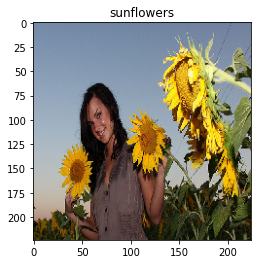

In [49]:
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)/255
plt.imshow(image_array)
plt.title(actual_label)
plt.show()

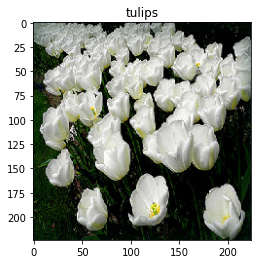

In [51]:
#Gather all code at one place
data = test_df.iloc[np.random.randint(0, test_length-1), :].values
image_path = data[0]
actual_label = data[1]

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)/255
plt.imshow(image_array)
plt.title(actual_label)
plt.show()

Now It is generating random image at each iteration

**Points to Remember:**
1. When we are using single images, image should be resized into which model is actually trained. Here our model is trained on image size (224, 224)
2. We trained our model in batches. So we need to make this single image into single batch

In [53]:
data = test_df.iloc[np.random.randint(0, test_length-1), :].values
image_path = data[0]
actual_label = data[1]

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)/255
image_batch = np.expand_dims(image_array, axis=0) #Batching our single image
model.predict(image_batch)

array([[1.4448329e-06, 9.9999774e-01, 6.1777212e-07, 1.2187175e-08,
        2.3202537e-07]], dtype=float32)

Model will produce 5 different probabilities for each image.Beacuse we have 5 classess. The max probability index is our predicted class

In [55]:
data = test_df.iloc[np.random.randint(0, test_length-1), :].values
image_path = data[0]
actual_label = data[1]

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)/255
image_batch = np.expand_dims(image_array, axis=0) #Batching our single image
print("Predicted label: ",np.argmax(model.predict(image_batch)))

Predicted label:  4


In [59]:
data = test_df.iloc[np.random.randint(0, test_length-1), :].values
image_path = data[0]
actual_label = data[1]

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)/255
image_batch = np.expand_dims(image_array, axis=0) #Batching our single image
predicted_label = class_indices[np.argmax(model.predict(image_batch))]

print("Predicted label: {}, Actual Label: {}".format(predicted_label, actual_label))

Predicted label: tulips, Actual Label: tulips


Yeah Pretty Good But now we plot Images

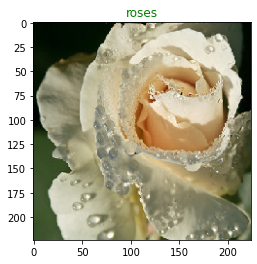

In [68]:
data = test_df.iloc[np.random.randint(0, test_length-1), :].values
image_path = data[0]
actual_label = data[1]

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)/255
image_batch = np.expand_dims(image_array, axis=0) #Batching our single image
predicted_label = class_indices[np.argmax(model.predict(image_batch))]
plt.imshow(image_array)
if actual_label == predicted_label:
  plt.title(predicted_label, color='green')
else:
  plt.title(predicted_label, color='red')

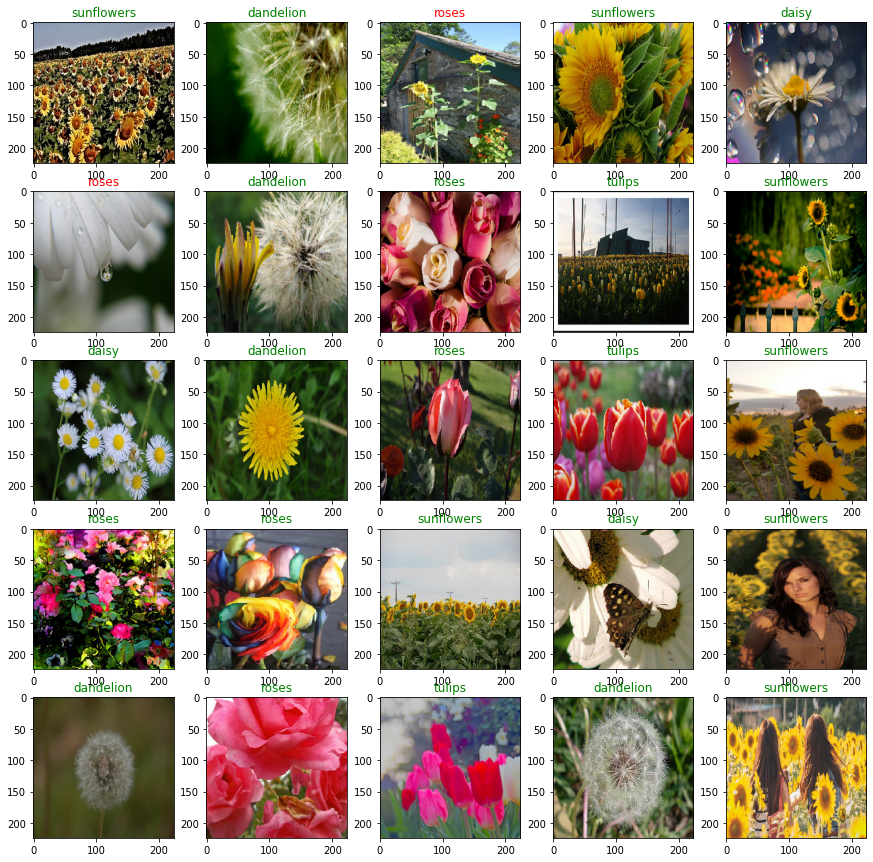

In [70]:
plt.figure(figsize=(15,15))
for i in range(25):
  ax = plt.subplot(5,5,i+1)
  data = test_df.iloc[np.random.randint(0, test_length-1), :].values
  image_path = data[0]
  actual_label = data[1]

  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
  image_array = tf.keras.preprocessing.image.img_to_array(image)/255
  image_batch = np.expand_dims(image_array, axis=0) #Batching our single image
  predicted_label = class_indices[np.argmax(model.predict(image_batch))]
  plt.imshow(image_array)
  if actual_label == predicted_label:
    plt.title(predicted_label, color='green')
  else:
    plt.title(predicted_label, color='red')

plt.show()

**WELCOME**